In [1]:
import pyspark

In [2]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.3.0
      /_/
                        
Using Scala version 2.12.15, OpenJDK 64-Bit Server VM, 11.0.17
Branch HEAD
Compiled by user ubuntu on 2022-06-09T19:58:58Z
Revision f74867bddfbcdd4d08076db36851e88b15e66556
Url https://github.com/apache/spark
Type --help for more information.


In [3]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
# import os
# os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages=org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell"

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [2]:
spark = SparkSession \
    .builder \
    .appName("Spark ML") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/13 12:10:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv("datasets/diabetes.csv",header = 'True',inferSchema='True')

In [4]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [5]:
type(df)

pyspark.sql.dataframe.DataFrame

In [6]:
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [7]:
df.describe().toPandas()

,summary,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,count,768,768,768,768,768,768,768,768,768
1,mean,3.8450520833333335,120.89453125,69.10546875,20.536458333333332,79.79947916666667,31.992578124999977,0.4718763020833327,33.240885416666664,0.3489583333333333
2,stddev,3.36957806269887,31.97261819513622,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.476951377242799
3,min,0,0,0,0,0,0.0,0.078,21,0
4,max,17,199,122,99,846,67.1,2.42,81,1


In [8]:

df.groupby('Outcome').count().toPandas()

,Outcome,count
0,1,268
1,0,500


In [9]:
df.count()

768

In [10]:
df.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



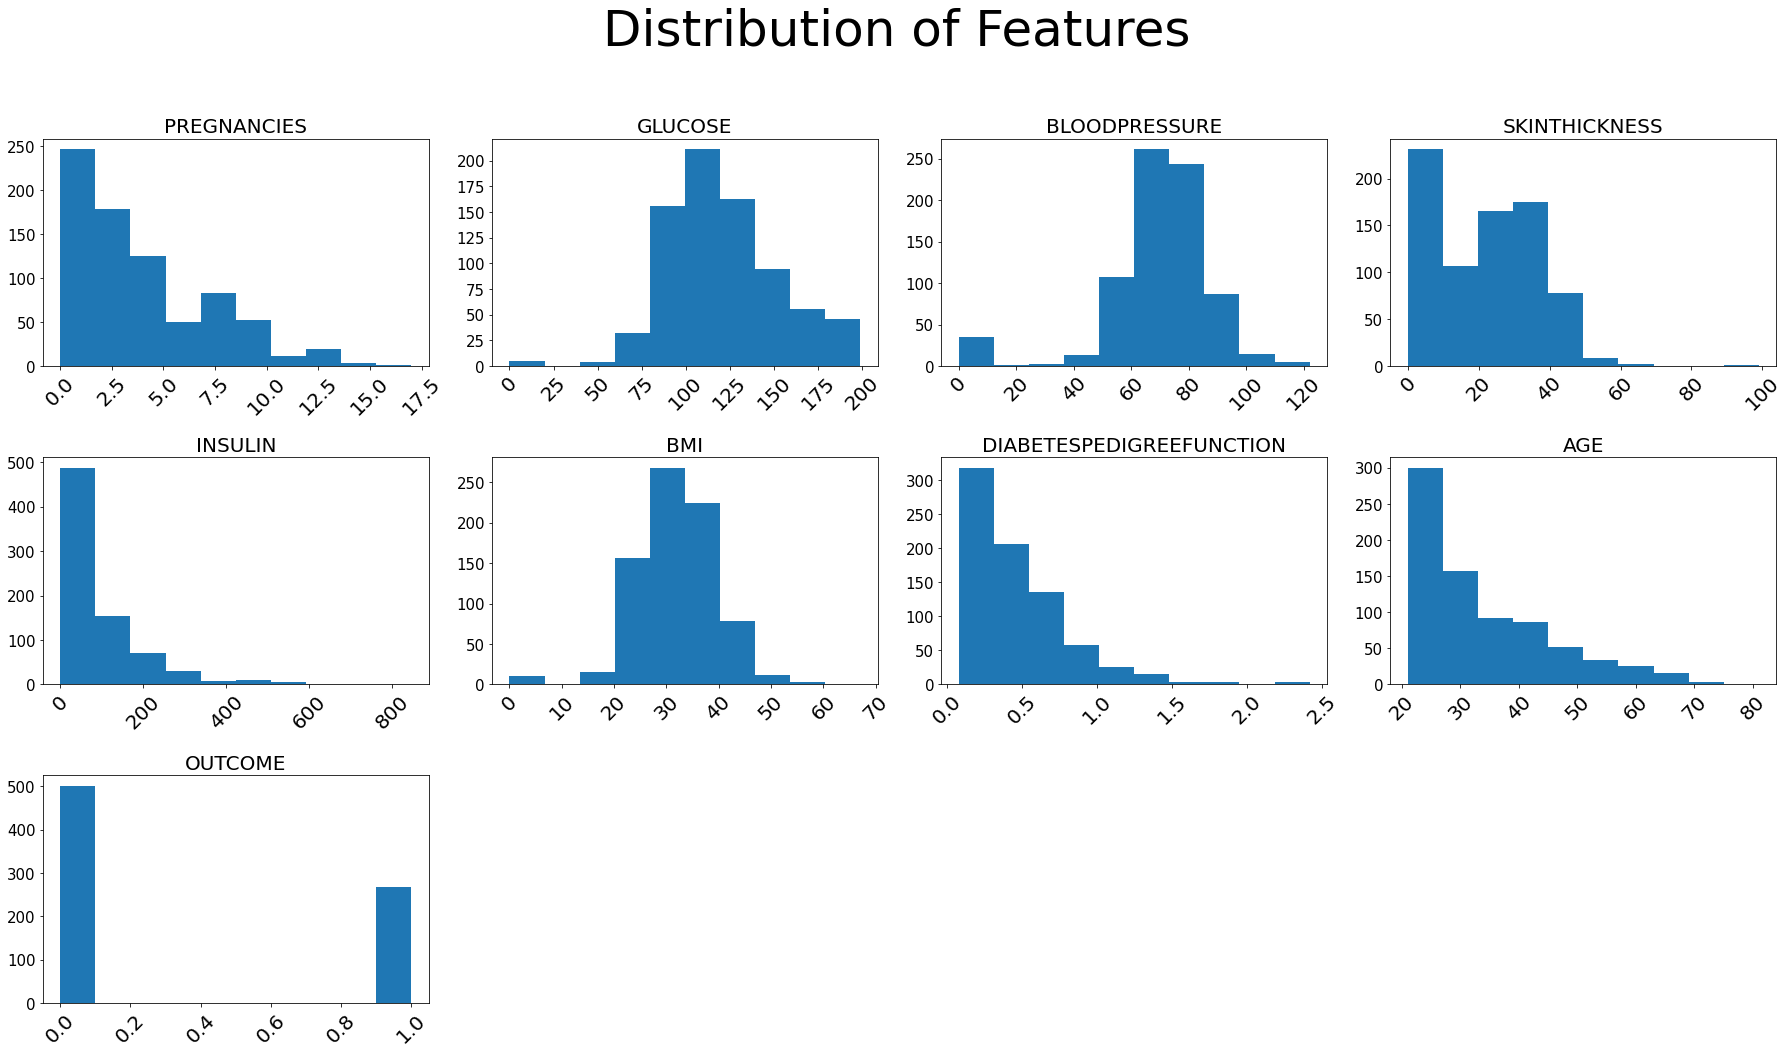

In [11]:
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
      ax = fig.add_subplot(3,4, num)
      ax.hist(df.toPandas()[col])
      plt.grid(False)
      plt.xticks(rotation=45, fontsize=20)
      plt.yticks(fontsize=15)
      plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [12]:
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


In [13]:
numeric_features = [t[0] for t in df.dtypes if t[1] !='string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [14]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [15]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [16]:
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54,0.22
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26,0.47
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24,0.07
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11,0.07
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04,0.13
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04,0.29
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03,0.17
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00,0.24
Outcome,0.22,0.47,0.07,0.07,0.13,0.29,0.17,0.24,1.00


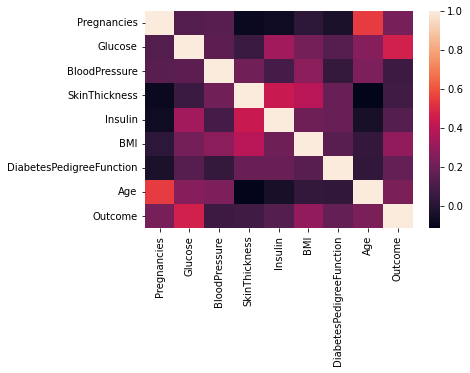

In [17]:
sns.heatmap(corr_df);

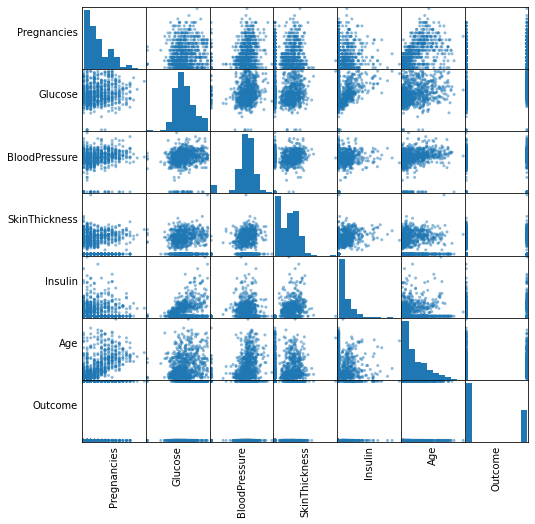

In [18]:
from pandas.plotting import scatter_matrix

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

numeric_data = df.select(numeric_features).toPandas()

axs = scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [19]:
# Drop unnecessary columns
df = df.drop('SkinThickness')
df = df.drop('DiabetesPedigreeFunction')
df = df.drop('Pregnancies')

df.show()

+-------+-------------+-------+----+---+-------+
|Glucose|BloodPressure|Insulin| BMI|Age|Outcome|
+-------+-------------+-------+----+---+-------+
|    148|           72|      0|33.6| 50|      1|
|     85|           66|      0|26.6| 31|      0|
|    183|           64|      0|23.3| 32|      1|
|     89|           66|     94|28.1| 21|      0|
|    137|           40|    168|43.1| 33|      1|
|    116|           74|      0|25.6| 30|      0|
|     78|           50|     88|31.0| 26|      1|
|    115|            0|      0|35.3| 29|      0|
|    197|           70|    543|30.5| 53|      1|
|    125|           96|      0| 0.0| 54|      1|
|    110|           92|      0|37.6| 30|      0|
|    168|           74|      0|38.0| 34|      1|
|    139|           80|      0|27.1| 57|      0|
|    189|           60|    846|30.1| 59|      1|
|    166|           72|    175|25.8| 51|      1|
|    100|            0|      0|30.0| 32|      1|
|    118|           84|    230|45.8| 31|      1|
|    107|           

In [20]:
# Assemble all the features with VectorAssembler

required_features = ['Glucose',
                    'BloodPressure',
                    'BMI',
                    'Age',
                    'Insulin'
                   ]
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=required_features, outputCol='features')

transformed_data = assembler.transform(df)
type(transformed_data)
transformed_data.show()

+-------+-------------+-------+----+---+-------+--------------------+
|Glucose|BloodPressure|Insulin| BMI|Age|Outcome|            features|
+-------+-------------+-------+----+---+-------+--------------------+
|    148|           72|      0|33.6| 50|      1|[148.0,72.0,33.6,...|
|     85|           66|      0|26.6| 31|      0|[85.0,66.0,26.6,3...|
|    183|           64|      0|23.3| 32|      1|[183.0,64.0,23.3,...|
|     89|           66|     94|28.1| 21|      0|[89.0,66.0,28.1,2...|
|    137|           40|    168|43.1| 33|      1|[137.0,40.0,43.1,...|
|    116|           74|      0|25.6| 30|      0|[116.0,74.0,25.6,...|
|     78|           50|     88|31.0| 26|      1|[78.0,50.0,31.0,2...|
|    115|            0|      0|35.3| 29|      0|[115.0,0.0,35.3,2...|
|    197|           70|    543|30.5| 53|      1|[197.0,70.0,30.5,...|
|    125|           96|      0| 0.0| 54|      1|[125.0,96.0,0.0,5...|
|    110|           92|      0|37.6| 30|      0|[110.0,92.0,37.6,...|
|    168|           

In [21]:
# Split the data
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])

## RandomForestClassifier

In [22]:
# Define the model
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='Outcome', 
                            featuresCol='features',
                            maxDepth=5)

In [23]:
# Fit the model
model = rf.fit(training_data)

In [24]:
# Predict with the test dataset
rf_predictions = model.transform(test_data)

In [25]:
type(rf_predictions)

pyspark.sql.dataframe.DataFrame

In [26]:
rf_predictions.show()

+-------+-------------+-------+----+---+-------+--------------------+--------------------+--------------------+----------+
|Glucose|BloodPressure|Insulin| BMI|Age|Outcome|            features|       rawPrediction|         probability|prediction|
+-------+-------------+-------+----+---+-------+--------------------+--------------------+--------------------+----------+
|     56|           56|     45|24.2| 22|      0|[56.0,56.0,24.2,2...|[19.6098310107897...|[0.98049155053948...|       0.0|
|     57|           80|      0|32.8| 41|      0|[57.0,80.0,32.8,4...|[16.3032212236646...|[0.81516106118323...|       0.0|
|     65|           72|      0|32.0| 42|      0|[65.0,72.0,32.0,4...|[16.9234026295602...|[0.84617013147801...|       0.0|
|     71|           48|     76|20.4| 22|      0|[71.0,48.0,20.4,2...|[19.6098310107897...|[0.98049155053948...|       0.0|
|     74|           68|     45|29.7| 23|      0|[74.0,68.0,29.7,2...|[18.9472273760569...|[0.94736136880284...|       0.0|
|     75|       

In [27]:
rf_predictions.toPandas()

,Glucose,BloodPressure,Insulin,BMI,Age,Outcome,features,rawPrediction,probability,prediction
0,56,56,45,24.2,22,0,"[56.0, 56.0, 24.2, 22.0, 45.0]","[19.60983101078976, 0.3901689892102377]","[0.9804915505394881, 0.019508449460511883]",0.0
1,57,80,0,32.8,41,0,"[57.0, 80.0, 32.8, 41.0, 0.0]","[16.3032212236646, 3.6967787763354005]","[0.8151610611832301, 0.18483893881677002]",0.0
2,65,72,0,32.0,42,0,"[65.0, 72.0, 32.0, 42.0, 0.0]","[16.923402629560293, 3.0765973704397087]","[0.8461701314780147, 0.15382986852198544]",0.0
3,71,48,76,20.4,22,0,"[71.0, 48.0, 20.4, 22.0, 76.0]","[19.60983101078976, 0.3901689892102377]","[0.9804915505394881, 0.019508449460511883]",0.0
4,74,68,45,29.7,23,0,"[74.0, 68.0, 29.7, 23.0, 45.0]","[18.94722737605691, 1.0527726239430866]","[0.9473613688028456, 0.052638631197154326]",0.0
...,...,...,...,...,...,...,...,...,...,...
141,177,60,478,34.6,21,1,"[177.0, 60.0, 34.6, 21.0, 478.0]","[6.225883524229522, 13.77411647577048]","[0.3112941762114761, 0.688705823788524]",1.0
142,180,0,0,43.3,41,1,"[180.0, 0.0, 43.3, 41.0, 0.0]","[4.618490089716049, 15.381509910283954]","[0.23092450448580243, 0.7690754955141976]",1.0
143,180,90,90,36.5,35,1,"[180.0, 90.0, 36.5, 35.0, 90.0]","[5.707879845538393, 14.292120154461609]","[0.28539399227691964, 0.7146060077230805]",1.0
144,187,68,304,37.7,41,1,"[187.0, 68.0, 37.7, 41.0, 304.0]","[3.4105112328634886, 16.589488767136512]","[0.17052556164317442, 0.8294744383568255]",1.0


In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Outcome', metricName = 'accuracy')
print('Random Forest classifier Accuracy:', multi_evaluator.evaluate(rf_predictions))

Random Forest classifier Accuracy: 0.7602739726027398


## DecisionTreeClassifier

In [29]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Outcome', maxDepth = 3)

dtModel = dt.fit(training_data)

dt_predictions = dtModel.transform(test_data)

dt_predictions.select('Glucose', 'BloodPressure', 'BMI', 'Age', 'Outcome').show(10)

+-------+-------------+----+---+-------+
|Glucose|BloodPressure| BMI|Age|Outcome|
+-------+-------------+----+---+-------+
|     56|           56|24.2| 22|      0|
|     57|           80|32.8| 41|      0|
|     65|           72|32.0| 42|      0|
|     71|           48|20.4| 22|      0|
|     74|           68|29.7| 23|      0|
|     75|           82|33.3| 38|      0|
|     77|           56|33.3| 24|      0|
|     80|           80|39.8| 28|      0|
|     81|           60|27.7| 25|      0|
|     82|           52|28.5| 25|      0|
+-------+-------------+----+---+-------+
only showing top 10 rows



In [30]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Outcome', metricName = 'accuracy')
print('Decision Tree Accuracy:', multi_evaluator.evaluate(dt_predictions))

Decision Tree Accuracy: 0.7945205479452054


## LogisticRegression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'Outcome', maxIter=10)
lrModel = lr.fit(training_data)
lr_predictions = dtModel.transform(test_data)

In [ ]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Outcome', metricName = 'accuracy')
print('Logistic Regression Accuracy:', multi_evaluator.evaluate(lr_predictions))

In [ ]:
test_data.columns

In [ ]:
training_data.columns

## GBTClassifier

In [ ]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(labelCol = 'Outcome', featuresCol = 'features')
gbModel = gb.fit(training_data)
gb_predictions = gbModel.transform(test_data)

In [ ]:
print('Gradient-boosted Trees Accuracy:', multi_evaluator.evaluate(gb_predictions))

In [31]:
# creating an empty list
new_features= []
  

Glucose = int(input("Enter la valeur Glucose : "))
BloodPressure = int(input("Enter la valeur BloodPressure : "))
Insulin = int(input("Enter la valeur Insulin : "))
BMI = int(input("Enter la valeur de BMI : "))
Age = int(input("Enter la valeur d'Age : "))

  
new_features.append(Glucose) # adding the element
new_features.append(BloodPressure) # adding the element
new_features.append(Insulin) # adding the element
new_features.append(BMI) # adding the element
new_features.append(Age) # adding the element


Enter la valeur Glucose : 1
Enter la valeur BloodPressure : 2
Enter la valeur Insulin : 12
Enter la valeur de BMI : 45
Enter la valeur d'Age : 15


In [32]:
from pyspark.ml.linalg  import Vectors
new_features=Vectors.dense(new_features)

In [33]:
print(new_features)

[1.0,2.0,12.0,45.0,15.0]


## prediction with gbostClassifier

In [35]:

if dtModel.predict(new_features)==0.0:
    print("test negatif")
else:
    print("test positif")
    


test negatif


In [36]:
df.show()

+-------+-------------+-------+----+---+-------+
|Glucose|BloodPressure|Insulin| BMI|Age|Outcome|
+-------+-------------+-------+----+---+-------+
|    148|           72|      0|33.6| 50|      1|
|     85|           66|      0|26.6| 31|      0|
|    183|           64|      0|23.3| 32|      1|
|     89|           66|     94|28.1| 21|      0|
|    137|           40|    168|43.1| 33|      1|
|    116|           74|      0|25.6| 30|      0|
|     78|           50|     88|31.0| 26|      1|
|    115|            0|      0|35.3| 29|      0|
|    197|           70|    543|30.5| 53|      1|
|    125|           96|      0| 0.0| 54|      1|
|    110|           92|      0|37.6| 30|      0|
|    168|           74|      0|38.0| 34|      1|
|    139|           80|      0|27.1| 57|      0|
|    189|           60|    846|30.1| 59|      1|
|    166|           72|    175|25.8| 51|      1|
|    100|            0|      0|30.0| 32|      1|
|    118|           84|    230|45.8| 31|      1|
|    107|           

In [37]:
# # Save model
dtModel.save('spark-kafka-module')

In [38]:
from pyspark.ml.classification import DecisionTreeClassificationModel
# Load model
loaded_model = DecisionTreeClassificationModel.load('spark-kafka-module')

In [39]:
df.write.csv("data.csv")

## loaded_model

In [41]:
if loaded_model.predict(new_features)==0.0:
    print("test negatif")
else:
    print("test positif")

test negatif


In [ ]:
!pip install --force-reinstall pyspark==2.4.6

In [ ]:
!pip install kafka-python
!pip install confluent_kafka

In [ ]:
# from kafka import KafkaProducer
# import json
# import csv
# import time
# def on_send_success(record_metadata):
#     print(record_metadata.topic)
#     print(record_metadata.partition)
#     print(record_metadata.offset)


# def on_send_error(excp):
#     log.error('I am an errback', exc_info=excp)


# if _name_ == "_main_":
#     target_topic = "topic1"
#     producer = KafkaProducer(bootstrap_servers='localhost:9092',value_serializer=lambda v: json.dumps(v).encode('utf-8'))
#     messages = ["salam","samir","rrrrrrrrrrrrr","eeeeeeeeeeeeeee"]

# with open('diabetes.csv') as file_obj:
#     heading = next(file_obj)
#     reader_obj = csv.reader(file_obj)
#     for row in reader_obj:
#         time.sleep(3)
#         data=[]
#         for j in row:
#           data.append(j)
#           print(j)

#         print(data)
#         producer.send(target_topic, json.dumps(data).encode()).add_callback(on_send_success).add_errback(on_send_error)
#         #producer.send(target_topic,row).add_callback(on_send_success).add_errback(on_send_error)
#         producer.flush(timeout=10) # this forcibly sends any messages that are stuck.
# producer.close(timeout=5)

In [ ]:
!pip install kafka

In [ ]:
# import json
# from kafka import KafkaConsumer

# #import findspark
# #findspark.init()
# #import pyspark # only run after findspark.init()
# import pickle
# #import pyspark
# import time
# import re
# #from pyspark.ml.classification import DecisionTreeClassificationModel
# # Load model
# #loaded_model = DecisionTreeClassificationModel.load('my_model_diabete1')

# stations = {}
# Listargument = []
# ##############
# entrained_model = 'finalized_model.sav'
# loaded_model = pickle.load(open(entrained_model,'rb'))
# ###################
# consumer = KafkaConsumer("topic1", bootstrap_servers='localhost:9092', group_id="consumertraitement")
# for message in consumer:
#     arguments = json.loads(message.value.decode())
   
#     prediction_data = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", arguments)
#     print("result of   ",prediction_data)
#     print("\n")
#     #for j in prediction_data :
#         #print(j)
#     #print("::::::::::::::::::")
   
 
#     # define input

# prediction_result = loaded_model.predict(prediction_data)
# ######################################################"
# # summarize input and output
# print("##################################################################")
# if prediction_result[0]==1.0 :
#     print("tested_positive")
# else :
#     print("tested_negative")
# #Listargument=[]